<a href="https://colab.research.google.com/github/az2611/Berkeley_Capstone_Final/blob/main/Berkeley_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Claims Description Classification**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Loss_Classification/Loss_Description.csv')

In [ ]:
df.head()

,Description,Class
0,VWF,Occupational disease/illness
1,CLAIMANT FELL AND INJURED WRIST,Fell
2,FELL ON ROADWAY AND INJURED BUTTOCKS,Fell
3,FELL ON RAIL TRACK NIL DED,Fell
4,STEEL FELL ON CLMNTS LEGS NIL DED,Fell


#### Task


**Text preprocessing:** As a pre-processing step, perform both `stemming` and `lemmatizing` to normalize your text before classifying. For each technique use both the `CountVectorize`r and `TfidifVectorizer` and use options for stop words and max features to prepare the text data for your estimator.

**Classification:** Once you have prepared the text data with stemming lemmatizing techniques, consider `LogisticRegression`, `DecisionTreeClassifier`, and `MultinomialNB` as classification algorithms for the data. Compare their performance in terms of accuracy and speed.

Share the results of your best classifier in the form of a table with the best version of each estimator, a dictionary of the best parameters and the best score.

# Data Exploration and Preparation

In [ ]:
df.describe()

,Description,Class
count,2311,2311
unique,2298,12
top,C Mesothelioma,Injury
freq,2,842


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  2311 non-null   object
 1   Class        2311 non-null   object
dtypes: object(2)
memory usage: 36.2+ KB


In [ ]:
#Remove Unknows
df = df[df.Class!='Unknown']
len(df)

2264

In [ ]:
possible_labels = df['Class'].unique()


In [ ]:
label_dict = {}
for index, possible_label in enumerate (possible_labels):
     label_dict[possible_label]=index 

In [ ]:
df['label']=df.Class.replace(label_dict)
df.head()

,Description,Class,label
0,VWF,Occupational disease/illness,0
1,CLAIMANT FELL AND INJURED WRIST,Fell,1
2,FELL ON ROADWAY AND INJURED BUTTOCKS,Fell,1
3,FELL ON RAIL TRACK NIL DED,Fell,1
4,STEEL FELL ON CLMNTS LEGS NIL DED,Fell,1


In [ ]:
df.groupby(['Class']).count()

,Description,label
Class,,
Auto-related,233,233
Damage,192,192
Fell,509,509
Fire,44,44
Flood,62,62
Injury,842,842
Occupational disease/illness,146,146
Pollution,62,62
Theft,15,15


In [ ]:
#Remove low classes
df = df[~df['Class'].isin(['auto-related','Theft'])]

In [ ]:
df.groupby(['Class']).count()

,Description,label
Class,,
Auto-related,233,233
Damage,192,192
Fell,509,509
Fire,44,44
Flood,62,62
Injury,842,842
Occupational disease/illness,146,146
Pollution,62,62
Water,157,157


Text(0, 0.5, 'Frequency')

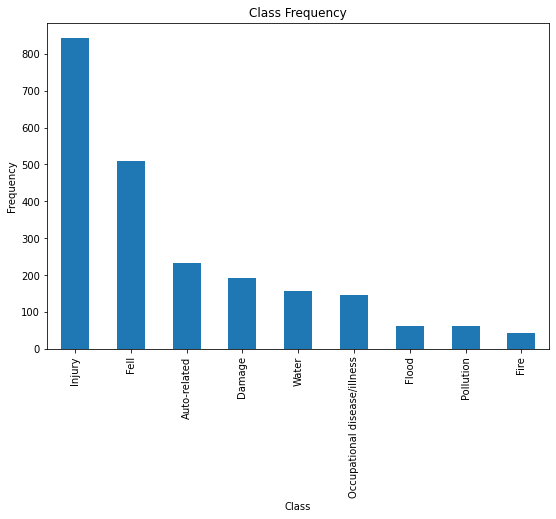

In [ ]:
ax = df['Class'].value_counts().plot(kind='bar',figsize=(9,6),title="Class Frequency")
ax.set_xlabel("Class")
ax.set_ylabel("Frequency")

In [ ]:
len(df)

2247

### Test / Train Set

In [ ]:
X = df.drop('Class', axis = 1)
y = df['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X['Description'], y, random_state = 42, stratify=y, test_size=0.3)

In [ ]:
print(len(X_train))
y_train.value_counts(normalize = True)

1572


Injury                          0.374682
Fell                            0.226463
Auto-related                    0.103690
Damage                          0.085242
Water                           0.069975
Occupational disease/illness    0.064885
Pollution                       0.027990
Flood                           0.027354
Fire                            0.019720
Name: Class, dtype: float64

In [ ]:
print(len(y_train))
y_test.value_counts(normalize = True)

1572


Injury                          0.374815
Fell                            0.226667
Auto-related                    0.103704
Damage                          0.085926
Water                           0.069630
Occupational disease/illness    0.065185
Flood                           0.028148
Pollution                       0.026667
Fire                            0.019259
Name: Class, dtype: float64

### PorterStemming

In [ ]:
def stemmer(text):
    stem = PorterStemmer()
    return ' '.join([stem.stem(w) for w in word_tokenize(text)])

In [ ]:
stemmed_X_train = X_train.apply(stemmer)
stemmed_X_test = X_test.apply(stemmer)

In [ ]:
results = pd.DataFrame(columns=['Model', 
                                'Stemming',
                                'Vectorizer', 
                                'Best Max Features', 
                                'Best Stop Words', 
                                'Score',
                                'Time'])

results.set_index('Model', inplace=True)

In [ ]:
params2 = {'vct__max_features': [100, 500, 1000, 2000, 3000, 4000],
          'vct__stop_words': ['english', None]}

In [ ]:
models = [('LogisticRegression_l2', LogisticRegression(max_iter=10000, penalty='l2')),('DecisionTree', DecisionTreeClassifier()), ('NaiveBayes', MultinomialNB())]
vectors = [('cvect', CountVectorizer()),('tdif',TfidfVectorizer())]

In [ ]:
#grid.get_params().keys()

In [ ]:
params2 = {'vct__max_features': [100, 500, 1000, 2000, 3000, 4000],
          'vct__stop_words': ['english', None]}

In [ ]:
iter_res = ''

for model in models:
        for vector in vectors:
            print('\nWorking on ', model[0], '+' ,vector[0] )
            pipe_1 = Pipeline([('vct', vector[1]),
                               ('mod', model[1])])
            
            grid = GridSearchCV(pipe_1, param_grid=params2, cv=5, scoring='accuracy', verbose=1)
            
            start_time = time.time()
            %time grid.fit(stemmed_X_train, y_train)
            end_time = time.time()
            
            test_acc = grid.score(stemmed_X_test, y_test)
            best_p = grid.best_params_
            
            Max_feat_item = list(best_p.items())[0]
            Max_feat_value = Max_feat_item[1]
            
            Best_stop_item = list(best_p.items())[1]
            Best_stop_value = Best_stop_item[1]
            
            fit_time = round(end_time - start_time,2)
            
            print('\nResults for: ', model[0], '+' ,vector[0] )
            print('\nAccuracy: ', test_acc)
            print('\nBest Parameters: ', best_p)
            print('\nFit Time: ', fit_time)
            
            iter_res= pd.DataFrame({'Model' : model[0], 
                                    'Stemming':'PorterStemmer()',
                                    'Vectorizer':vector[0], 
                                    'Best Max Features' : Max_feat_value, 
                                    'Best Stop Words' : Best_stop_value,  
                                    'Score' : test_acc,
                                    'Time' : fit_time 
                                   }, index=[0])
            
            iter_res.set_index('Model', inplace=True)
            results = pd.concat([results, iter_res], axis=0)


Working on  LogisticRegression_l2 + cvect
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 9.97 s, sys: 4.2 s, total: 14.2 s
Wall time: 12.4 s

Results for:  LogisticRegression_l2 + cvect

Accuracy:  0.8637037037037038

Best Parameters:  {'vct__max_features': 500, 'vct__stop_words': None}

Fit Time:  12.37

Working on  LogisticRegression_l2 + tdif
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 10.2 s, sys: 5.21 s, total: 15.4 s
Wall time: 12.5 s

Results for:  LogisticRegression_l2 + tdif

Accuracy:  0.8340740740740741

Best Parameters:  {'vct__max_features': 500, 'vct__stop_words': None}

Fit Time:  12.5

Working on  DecisionTree + cvect
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 2.02 s, sys: 5.16 ms, total: 2.03 s
Wall time: 2.04 s

Results for:  DecisionTree + cvect

Accuracy:  0.8355555555555556

Best Parameters:  {'vct__max_features': 2000, 'vct__stop_words': None}

Fit Time:  2.04

Workin

### WordNetLemmatizing

In [ ]:
def lemma(text):
    lemma = WordNetLemmatizer()
    return ' '.join([lemma.lemmatize(w) for w in word_tokenize(text)])

In [ ]:
lemma_X_train = X_train.apply(lemma)
lemma_X_test = X_test.apply(lemma)

In [ ]:
iter_res = ''

for model in models:
        for vector in vectors:
            print('\nWorking on ', model[0], '+' ,vector[0] )
            pipe_1 = Pipeline([('vct', vector[1]),
                               ('mod', model[1])])
            grid = GridSearchCV(pipe_1, param_grid=params2, cv=5, scoring='accuracy', verbose=1)
            
            start_time = time.time()
            %time grid.fit(lemma_X_train, y_train)
            end_time = time.time()
            
            fit_time = round(end_time - start_time,2)
            
            test_acc = grid.score(lemma_X_test, y_test)
            
            best_p = grid.best_params_
            
            Max_feat_item = list(best_p.items())[0]
            Max_feat_value = Max_feat_item[1]
            
            Best_stop_item = list(best_p.items())[1]
            Best_stop_value = Best_stop_item[1]
            
            print('\nResults for: ', model[0], '+' ,vector[0] )
            print('\nAccuracy: ', test_acc)
            print('\nBest Parameters: ', best_p)
            print('\nFit Time: ', fit_time)
            
            iter_res= pd.DataFrame({'Model' : model[0], 
                                    'Stemming':'WordNetLemmatizer()',
                                    'Vectorizer':vector[0], 
                                    'Best Max Features' : Max_feat_value, 
                                    'Best Stop Words' : Best_stop_value,  
                                    'Score' : test_acc,
                                    'Time' : fit_time 
                                   }, index=[0])
            
            iter_res.set_index('Model', inplace=True)
            results = pd.concat([results, iter_res], axis=0)



Working on  LogisticRegression_l2 + cvect
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 12.7 s, sys: 12.2 s, total: 24.9 s
Wall time: 16.1 s

Results for:  LogisticRegression_l2 + cvect

Accuracy:  0.8548148148148148

Best Parameters:  {'vct__max_features': 500, 'vct__stop_words': None}

Fit Time:  16.09

Working on  LogisticRegression_l2 + tdif
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 14 s, sys: 11.9 s, total: 25.9 s
Wall time: 16.6 s

Results for:  LogisticRegression_l2 + tdif

Accuracy:  0.837037037037037

Best Parameters:  {'vct__max_features': 500, 'vct__stop_words': None}

Fit Time:  16.62

Working on  DecisionTree + cvect
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 3.16 s, sys: 357 µs, total: 3.16 s
Wall time: 3.22 s

Results for:  DecisionTree + cvect

Accuracy:  0.8148148148148148

Best Parameters:  {'vct__max_features': 3000, 'vct__stop_words': None}

Fit Time:  3.22

Working 

In [ ]:
results.sort_values(by='Score', ascending=False, inplace=True)

### Results

In [ ]:
results

,Stemming,Vectorizer,Best Max Features,Best Stop Words,Score,Time
Model,,,,,,
LogisticRegression_l2,PorterStemmer(),cvect,500,None,0.863704,12.37
LogisticRegression_l2,WordNetLemmatizer(),cvect,500,None,0.854815,16.09
LogisticRegression_l2,WordNetLemmatizer(),tdif,500,None,0.837037,16.62
DecisionTree,PorterStemmer(),cvect,2000,None,0.835556,2.04
LogisticRegression_l2,PorterStemmer(),tdif,500,None,0.834074,12.50
DecisionTree,WordNetLemmatizer(),tdif,1000,None,0.819259,2.92
DecisionTree,WordNetLemmatizer(),cvect,3000,None,0.814815,3.22
DecisionTree,PorterStemmer(),tdif,500,None,0.811852,2.75
NaiveBayes,WordNetLemmatizer(),cvect,500,english,0.800000,1.22


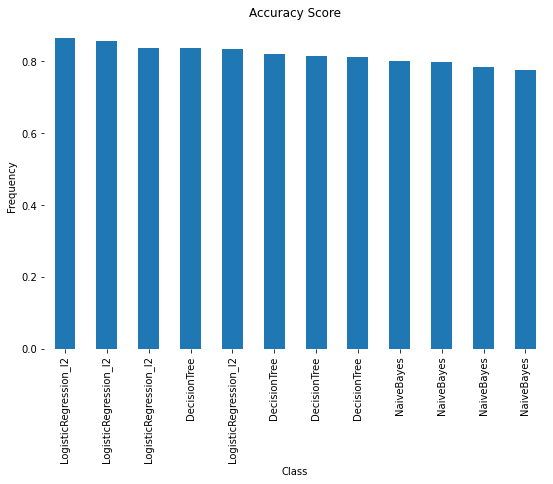

In [ ]:
ar = results['Score'].plot(kind='bar',figsize=(9,6),title="Accuracy Score")
sns.despine(left=True, bottom=True)
ar.set_xlabel("Class")
ar.set_ylabel("Frequency")
sns.despine(left=True, bottom=True)

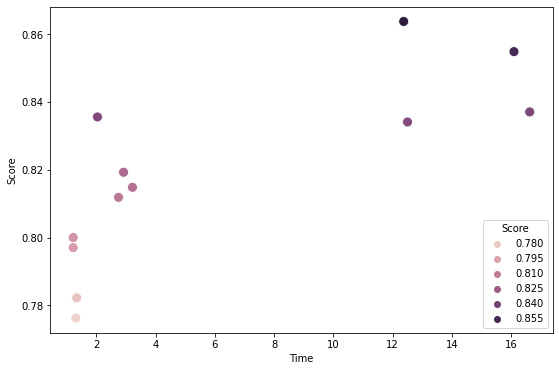

In [ ]:
plt.figure(figsize=(9, 6))
sns.scatterplot(data=results, x='Time', y='Score', hue='Score', s=100)
plt.show()

In [ ]:
total_fitting_time = results['Time'].sum()
total_fitting_time = total_fitting_time/60
print('Total Fitting Time (min) =', round(total_fitting_time,2))

Total Fitting Time (min) = 1.23


In [ ]:
# Perform an aggregation on the groups
grouped = results.groupby(['Stemming','Model'])
result_g = grouped['Time'].sum()
pd.DataFrame(result_g) 

Time
Stemming            Model                       
PorterStemmer()     DecisionTree            4.79
                    LogisticRegression_l2  24.87
                    NaiveBayes              2.53
WordNetLemmatizer() DecisionTree            6.14
                    LogisticRegression_l2  32.71
                    NaiveBayes              2.56